In [3]:
import subprocess
subprocess.run("ssh slave2 'cd /usr/local/spark/work/; rm -r ./*'", shell=True)

CompletedProcess(args="ssh slave2 'cd /usr/local/spark/work/; rm -r ./*'", returncode=0)

In [1]:
from sklearn.datasets import fetch_kddcup99
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# pip install scikit-learn

### Brief section of LOCAL K-Means (and related) functions:

In [3]:
def localPlusPlusInit(points, k): 
    #print('pointsshape: ', points.shape)
    '''
    points is a numpy array (n,dim)
    '''
    C=points[np.random.choice(points.shape[0])]#sample from array di punti ecc...
    C=C[np.newaxis, :]
    for _ in range(k):
        #points is array (n, dim), C is array(g<=k, dim)
        #probs is array (n,1)
        probs=np.min(np.sum((points[:,:,np.newaxis]-C.T[np.newaxis,:,:])**2, axis=1), axis=1).flatten()
        #probs=[min([sum((point-centroid)**2) for centroid in C]) for point in points] #numpyfy this, or numbafy if left base python
        probs=probs/np.sum(probs)
        nextCentroid=points[np.random.choice(points.shape[0], p=probs)][np.newaxis,:]
        #print('LE FORME',C.shape, nextCentroid.shape)
        C=np.vstack((C, nextCentroid))
    return C
#Inventare test

In [4]:
# Function to compute weighted average, given 
def weightedAverage(group):
    weight_column='weights'
    groupby_column='clusterId'
    columns_to_average = group.columns.difference([weight_column, groupby_column])
    weighted_averages = group[columns_to_average].multiply(group[weight_column], axis=0).sum() / group[weight_column].sum()
    return weighted_averages
def localLloyds(points, k, weights=None, n_iterations=100):
    df=pd.DataFrame(points)
    if weights is None:
        weights=np.ones(shape=len(points))
    #print('weights', weights)
    df['weights']=weights
    df['clusterId']=np.zeros(shape=len(points))
    C=localPlusPlusInit(points, k)
    #print('localPlusPluisInit: ', C)
    clusterId=np.argmin(np.sum((points[:,:,np.newaxis]-C.T[np.newaxis,:,:])**2, axis=1), axis=1)
    for iteration in range(n_iterations):
        df['clusterId']=clusterId
        C_df=df.groupby('clusterId')\
            .apply(weightedAverage)\
            .reset_index()
        C_array=C_df[C_df.columns.difference(['weights', 'clusterId'])].reset_index(drop=True).to_numpy()
        clusterId=np.argmin(np.sum((points[:,:,np.newaxis]-C_array.T[np.newaxis,:,:])**2, axis=1), axis=1)
        #print(clusterId)
        
    return C_array   

### Beginning of the PARALLELIZED section

In [5]:
# import the python libraries to create/connect to a Spark Session
from pyspark.sql import SparkSession

# build a SparkSession 
#   connect to the master node on the port where the master node is listening (7077)
#   declare the app name 
#   configure the executor memory to 512 MB
#   either *connect* or *create* a new Spark Context
spark = SparkSession.builder \
    .master("spark://spark-master:7077")\
    .appName("My first spark application")\
    .config("spark.executor.memory", "512m")\
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/07/03 15:54:21 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [6]:
# create a spark context
sc = spark.sparkContext

In [7]:
data = fetch_kddcup99(return_X_y = True)

In [8]:
len(data[0])

494021

In [9]:
x= data[0]
x = x[:, 4:]

In [10]:
print(x.shape)

(494021, 37)


In [11]:
y = data[1] 

In [52]:
#Let's define a map from Y (set of strings) into (0,size(Y)) for easier usage
def labelToInt(label):
    uniqueLabels=list(np.unique(y))
    return uniqueLabels.index(label)

In [13]:
#We now shuffle the data array to have more varied labels
shuffled_indices = np.random.permutation(len(x))
x=x[shuffled_indices]
y=y[shuffled_indices]

In [14]:
# to delete later on
subLen = 1000
x = x[:subLen,]
y = y[:subLen]

In [15]:
for i in range (x.shape[1]):
    print(len(np.unique(x[:, i])))
    


117
127
1
3
1
2
1
2
2
1
1
2
1
1
2
1
1
1
184
74
3
3
4
6
21
11
31
71
73
44
32
32
20
6
4
11
16


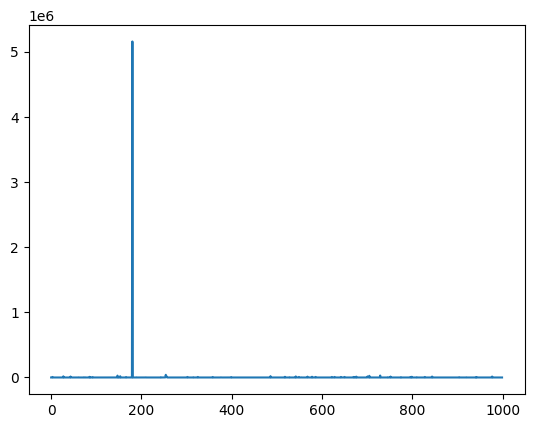

In [16]:
plt.plot(x[:,1])

In [17]:
kTarget = len(set(y))
nSamples = x.shape[0]
print(kTarget)

9


In [18]:
nSlice = None
Rdd = sc.parallelize([(None, {"x": x[i],"y": y[i], "d2":None}) for i in range(nSamples)], numSlices = nSlice)
# add persist later on
print(Rdd.takeSample(False, 3)[0][1]['x'].shape)

(37,)


In [19]:
Rdd.getNumPartitions() # check partitions

2

In [20]:
def minmaxRescale(datum, minS, maxS):
    mask = (minS < maxS).astype(bool)
    feature = datum[1]["x"] 
    feature = (feature[mask] - minS[mask])/(maxS[mask] - minS[mask])
    return (datum[0], {"x": feature, "y": datum[1]["y"], "d2":datum[1]["d2"]})   



In [21]:
%%time
maxS = Rdd.map(lambda datum: datum[1]["x"])\
           .reduce(lambda a, b: np.maximum(a, b))
minS = Rdd.map(lambda datum: datum[1]["x"])\
           .reduce(lambda a, b: np.minimum(a, b))

print(maxS.shape)
print((minS < maxS).astype(bool))

(37,)
[ True  True False  True False  True False  True  True False False  True
 False False  True False False False  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True]
CPU times: user 4.42 ms, sys: 5.33 ms, total: 9.75 ms
Wall time: 405 ms


In [22]:
a,b=np.array([1,3,5]), np.array([2,1,5])
print(np.maximum(a,b))

[2 3 5]


In [23]:
print(*zip(minS, maxS))
print((minS < maxS).astype(bool).shape)

(0, 54540) (0, 5153771) (0, 0) (0, 3) (0, 0) (0, 2) (0, 0) (0, 1) (0, 1) (0, 0) (0, 0) (0, 1) (0, 0) (0, 0) (0, 1) (0, 0) (0, 0) (0, 0) (1, 511) (1, 511) (0.0, 1.0) (0.0, 1.0) (0.0, 1.0) (0.0, 1.0) (0.0, 1.0) (0.0, 1.0) (0.0, 1.0) (1, 255) (1, 255) (0.0, 1.0) (0.0, 1.0) (0.0, 1.0) (0.0, 1.0) (0.0, 1.0) (0.0, 1.0) (0.0, 1.0) (0.0, 1.0)
(37,)


In [24]:
#### fix ####
# %%time
# results = Rdd.map(lambda datum: datum["x"])\
#               .reduce(lambda a, b: (np.maximum(a[0], b[0]), np.minimum(a[1], b[1]))

In [25]:
Rdd = Rdd.map(lambda datum: minmaxRescale(datum, minS, maxS))
print(Rdd.takeSample(False, 3)[0][1]['x'].shape)


(27,)


In [26]:
local_datum=Rdd.takeSample(False, 3)[0]
print(local_datum)

(None, {'x': array([0.009534286762009535, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0,
       0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0,
       0.0, 0.0, 0.0, 0.0], dtype=object), 'y': b'smurf.', 'd2': None})


In [27]:
def selectCluster(datum, C, updateDistances=True):
    """
    dimC(k, len(datum))
    """
    distances = np.sum((datum[1]["x"] - C)**2, axis=1)
    print('distances: ',distances)
    clusterId = np.argmin(distances)
    if updateDistances is True:
        return (clusterId, {'x':datum[1]['x'], 'y':datum[1]['y'], 'd2':distances[clusterId]})
    else:
        return (clusterId, datum[1])

In [28]:
'''
C_init=naiveInitFromSpace(14, len(local_datum[1]['x']))
print(C_init.shape)
'''

"\nC_init=naiveInitFromSpace(14, len(local_datum[1]['x']))\nprint(C_init.shape)\n"

In [29]:
'''
C_init=[el for el in C_init]
print(selectCluster(local_datum, C_init))
'''

'\nC_init=[el for el in C_init]\nprint(selectCluster(local_datum, C_init))\n'

In [30]:
#update centroids as 'centers of mass' of clusters
def updateCentroids(Rdd):
    C=Rdd.mapValues(lambda xy: (xy['x'], 1))\
              .reduceByKey(lambda a,b : (a[0]+b[0], a[1]+b[1]))\
              .mapValues(lambda a:a[0]/a[1])\
              .values()\
              .collect() 
    C=np.array(C) #check later more carefully if causes some overhead
    return C


In [31]:
#lets assume entry of xy dictionary to be distance of point from its centroid
# ADD IF NOT TIME CONSUMING d ENTRY IN XY DICTIONARY FOR CONSISTENCY

#update the Rdd with square distances from centroids, given Rdd with centroids already updated 
def updateDistances(Rdd, C):
    def datumUpdate(datum, C):
        d2=np.sum((datum[1]['x']-C[datum[0]])**2)
        #return datum
        return (datum[0], {"x": datum[1]["x"], "y": datum[1]["y"], "d2":d2})
    Rdd=Rdd.map(lambda datum:datumUpdate(datum, C))
    return Rdd
#calculate global cost of X,C from an Rdd with distances from centroids already updated
def cost(Rdd):
    my_cost=Rdd.map(lambda datum : datum[1]['d2'])\
       .reduce(lambda a,b: a+b)
    return my_cost 

In [32]:
#updateDistances(Rdd, Rdd.takeSample(False, 1)[0][1]['x']).takeSample(False, 10)

In [33]:
my_kMeansCosts=[]
def kMeans(Rdd, C_init, maxIterations):
    C=C_init
    for t in range(maxIterations):
        Rdd = Rdd.map(lambda datum: selectCluster(datum, C))
        my_kMeansCosts.append(cost(Rdd))
        # Now we compute the new centroids by calculating the averages of points belonging to the same cluster.
        # Need to check that all centroids are assigned to at least one point, otherwise k changes!!! Solutions?!
        C=updateCentroids(Rdd)
    return C

Different initialization functions

In [34]:
def naiveInitFromSet(Rdd, k):
    #uniform sampling of k points from Rdd
    kSubset=Rdd.takeSample(False, k)
    # Replacement is set to False to avoid coinciding centroids BUT no guarantees that in the original dataset all points are distinct!!! Check if causes problems in the algorithm (i.e. need to pre-filter) or it's ok
    C_init=np.array([datum[1]['x'] for datum in kSubset])
    return C_init
def naiveInitFromSpace(k, dim):
    #uniform drawing of k points from euclidean space
    #we assume the Rdd has been mapped into a [0,1]^dim space
    C_init=np.random.uniform(size=(k,dim))
    return C_init

In [35]:
'''
1: C ← sample a point uniformly at random from X
2: ψ ← φX (C)
3: for O(log ψ) times do
4:
C 0 ← sample each point x ∈ X independently with
2
(x,C)
probability px = `·d
φX (C)
0
5:
C ←C∪C
6: end for
7: For x ∈ C, set wx to be the number of points in X closer
to x than any other point in C
8: Recluster the weighted points in C into k clusters
'''
my_parallelInitCosts=[]
my_Cs=[]
my_populations=[]
my_takes=[]
my_distances=[]
def parallelInit(Rdd, k, l):
    C=naiveInitFromSet(Rdd, 1)
    Rdd=Rdd.map(lambda datum : (0, datum[1]))
    Rdd=updateDistances(Rdd, C)
    my_cost=cost(Rdd)
    n_iterations=int(np.log(my_cost))
    if(n_iterations<1):
        n_iterations=1
    for _ in range(n_iterations):
        my_parallelInitCosts.append(my_cost)
        
        #my_takes.append(Rdd.take(3))
        
        C_prime=Rdd.filter(lambda datum : np.random.uniform()<l*datum[1]['d2']/my_cost)\
                   .map(lambda datum : datum[1]['x'])\
                   .collect()
        C_prime=np.array(C_prime)
        if (C_prime.shape[0]>0):
            C=np.vstack((C, C_prime))
            #Rdd=Rdd.map(lambda datum : (0, datum[1]))
            Rdd=Rdd.map(lambda datum: selectCluster(datum, C))
            #my_Cs.append(C)
            #my_populations.append((list(Rdd.countByKey().keys()),list(Rdd.countByKey().values())))
            #Rdd=updateDistances(Rdd, C).persist()
            #my_distances.append(Rdd.map(lambda datum:datum[1]['d2']).collect())
            my_cost=cost(Rdd)
    #erase centroids sampled more than once 
    C=C.astype(float)
    #print('original',C)
    C=np.unique(C, axis=0)
    #print('unique',C)
    Rdd=Rdd.map(lambda datum: selectCluster(datum, C))
    #compute weights of centroids (sizes of each cluster) and put them in a list whose index is same centroid index as C
    wx=Rdd.countByKey()
    #print('dict',dict(wx))
    #print('*wx',*wx)
    #print('zip(*wx)',zip(*wx))
    #print('list',list(zip(*wx)))
    #wx=list(zip(*wx))
    #print(list(wx.keys()), list(wx.values()))
    weights=np.zeros(len(C))
    weights[[list(wx.keys())]]=[list(wx.values())]
    #subselection of k centroids from C, using local Lloyds algorithm with k-means++ initialization
    if C.shape[0]<=k:
        C_init=C
    else:
        C_init=localLloyds(C, k, weights=weights, n_iterations=100)
    return C_init
    

In [36]:
arr=np.zeros(5)
print(arr)
tuplas=[(3,2),(4,1),(2,12)]
untuplas=list(zip(*tuplas))
print(untuplas)
arr[[untuplas[0]]]=[untuplas[1]]
print(arr)

[0. 0. 0. 0. 0.]
[(3, 4, 2), (2, 1, 12)]
[ 0.  0. 12.  2.  1.]


In [37]:
#print(naiveInitFromSet(Rdd, 14).shape)
#print(Rdd.takeSample(False, 3)[0][1]['x'])

In [38]:
%%time
k=kTarget
l=kTarget*2
#print(kMeans(Rdd, naiveInitFromSet(Rdd, 2), 10))
C_predicted=kMeans(Rdd, parallelInit(Rdd, k, l), 15)
Rdd=Rdd.map(lambda datum: selectCluster(datum, C_predicted))

CPU times: user 1.01 s, sys: 57.3 ms, total: 1.07 s
Wall time: 48.1 s


In [39]:
'''
a=np.array([[1],[2],[3]])
b= np.array([[4],[5],[6]])
print(a*b)
'''
D=np.array([[1,2,3,1],[1,2,3,1],[4,5,6,4],[9,8,7,9]])
print(type(D), D.shape)
print(np.unique(D, axis=0))

<class 'numpy.ndarray'> (4, 4)
[[1 2 3 1]
 [4 5 6 4]
 [9 8 7 9]]


costs [2765.8556627746616, 161.52089638847679, 42.92502297601386, 19.744430220783535, 7.309005266580094, 3.704583008776641, 1.2234476911250725]
7


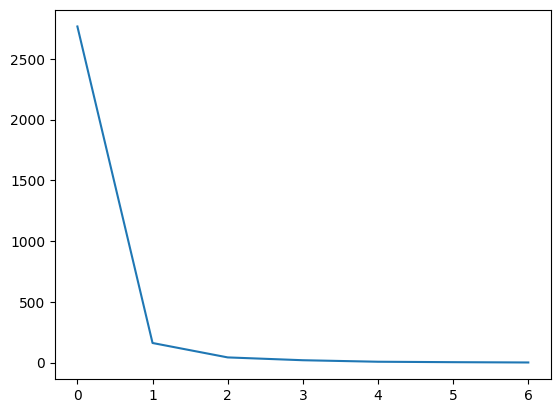

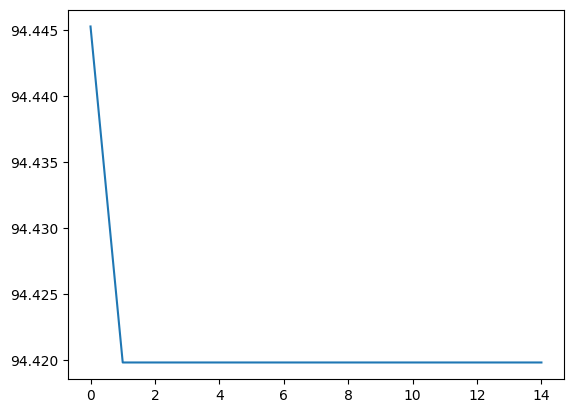

'\nfor dist in my_distances:\n    #print(dist)\n    plt.plot(dist)\n    plt.show()\n'

In [40]:
print('costs',my_parallelInitCosts)
print(len(my_parallelInitCosts))
plt.plot(my_parallelInitCosts)
plt.show()
plt.plot(my_kMeansCosts)
plt.show()
for C in my_Cs:
    print(C.shape)
    '''
    for point in C:
        plt.bar(np.arange(len(point)), point)
    plt.show()
    '''
#print('costfromdistsum: ', sum(my_distances[0]))
for pop in my_populations:
    print(pop)
'''
for dist in my_distances:
    #print(dist)
    plt.plot(dist)
    plt.show()
''' 

### Now we want to test the agreement between expected cluster labels "y" and resulted labels clusterId

In [86]:
expectedRdd=Rdd.map(lambda datum:(labelToInt(datum[1]['y']), datum[1])) #put y-label as clusterId
C_expected=updateCentroids(expectedRdd) #compute centroids coordinate
expectedRdd=updateDistances(expectedRdd, C_expected) #update and save squared distances points-centroids
print(expectedRdd.take(10))

[(6, {'x': array([0.009534286762009535, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0,
       0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0,
       0.0, 0.0, 0.0, 0.0], dtype=object), 'y': b'smurf.', 'd2': 3.8386647365059328}), (2, {'x': array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4372549019607843,
       0.021568627450980392, 1.0, 1.0, 0.0, 0.0, 0.05, 0.06, 0.0, 1.0,
       0.04330708661417323, 0.05, 0.06, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0],
      dtype=object), 'y': b'neptune.', 'd2': 8.919118385501514}), (2, {'x': array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2627450980392157,
       0.0058823529411764705, 1.0, 1.0, 0.0, 0.0, 0.03, 0.06, 0.0, 1.0,
       0.05511811023622047, 0.06, 0.07, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0],
      dtype=object), 'y': b'neptune.', 'd2': 8.817470419421422}), (3, {'x': array([0.003942060872753942, 0.0016341432322080278, 0.0, 0.0, 1.0, 0.0,
       0.0, 0.0, 0.01568627450980392, 0.01764705882352941, 0.0, 0.0, 0.0,
       0.0, 1.0, 0.0, 0.2, 1.

First, we compare the cluster populations

In [ ]:
predictedPopulationDict=Rdd.countByKey()
predictedPopulationDict = dict(sorted(predictedPopulationDict.items(), key=lambda item: item[1], reverse=True))
expectedPopulationDict=Rdd.map(lambda datum:(datum[1]['y'], datum[1])).countByKey()
expectedPopulationDict = dict(sorted(expectedPopulationDict.items(), key=lambda item: item[1], reverse=True))
print('predictedPopulationDict', predictedPopulationDict)
plt.bar(np.arange(len(predictedPopulationDict)), predictedPopulationDict.values())
plt.show()
print('expectedPopulationDict',expectedPopulationDict)
plt.bar(np.arange(len(expectedPopulationDict)), expectedPopulationDict.values())
plt.show()

Now we want to calculate the mean square error between expected centroids and the nearest predicted centroids

idea: plottare errorbars pari alle std degli expected cluster rispetto agli expected centroids e plottare sopra esso (barplot) il displacement dei predicted centroids piu vicini 

In [60]:
def predictedCentroidsLabeler(C_expected, C_predicted):
    distMatrix=np.sum((C_expected[:,:,np.newaxis]-C_predicted.T[np.newaxis, :,:])**2,axis=1)
    #the labeler i-th entry j, tells that i-th centroid of C_expected is associated to j-th element of C_predicted
    labeler=np.argmin(distMatrix,axis=1)
    #square distance of element of C_expected to nearest point in C_predicted
    distances=distMatrix[np.arange(len(distMatrix)),labeler]
    return labeler, distances

In [61]:
print('k_expected, k_predicted: ', len(C_expected), len(C_predicted))
labeler, distances=predictedCentroidsLabeler(C_expected, C_predicted)
meanSquaredError=np.mean(distances)
print('labeler: ', labeler)
print('meanSquaredError: ', meanSquaredError)

k_expected, k_predicted:  9 10
labeler:  [5 0 2 9 2 6 2 1 2]
meanSquaredError:  1.1911773222449906


In [82]:
#standard deviation of cluster from expected centroids
#stdExpected=updateDistances(Rdd.map(lambda datum: (datum[1]['y'], datum[1])), C_expected).collect()
stdExpected=expectedRdd.mapValues(lambda datum1: (datum1['d2'], 1))\
                        .reduceByKey(lambda a,b : (a[0]+b[0], a[1]+b[1]))\
                        .mapValues(lambda a:a[0]/a[1])\
                        .collect()
stdExpected=list(zip(*stdExpected))
print(stdExpected)

[(6, 2, 8, 0, 4, 3, 1, 5, 7), (3.8131208197241238, 8.887558336400062, 3.4625306907736375, 7.4322624191366895, 0.0, 4.26419643152513, 8.201171261257366, 7.010992772719054, 6.596250802508998)]


[0.0 0.406836932663408 2.548430068307378 0.0715047165308817
 2.0052855888377943 0.15789793985425019 1.9186021370076582
 2.3372357785463707 1.2748027384571732]


<BarContainer object of 9 artists>

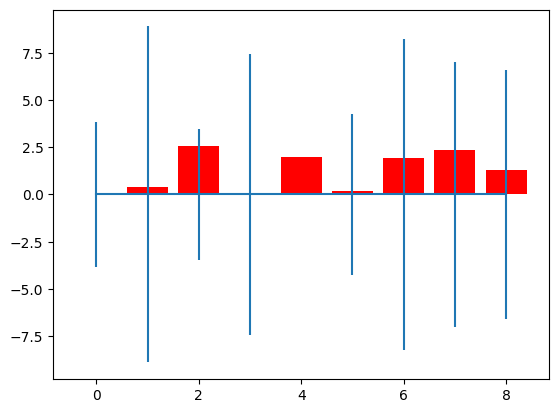

In [90]:
plt.errorbar(np.arange(len(C_expected)), np.zeros(shape=(len(stdExpected[0]))), stdExpected[1])
print(distances)
plt.bar(np.arange(len(C_expected)), distances, color='red')

In [92]:
print(C_expected[0])

[0.017339007133879883 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.9930537824478709
 0.9930472355887265 0.0 0.0 0.0 0.0 1.0 0.0 0.0 1.0 1.0 1.0 0.0 1.0 0.0
 0.0 0.0 0.0 0.0]


In [94]:
print(C_predicted[5])

[0.017339007133879883 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.9930537824478709
 0.9930472355887265 0.0 0.0 0.0 0.0 1.0 0.0 0.0 1.0 1.0 1.0 0.0 1.0 0.0
 0.0 0.0 0.0 0.0]


# MOLTO STRANO CHE VENGANO PRIOPRIO UGUALI...